In [9]:
!pip install -q tweet-preprocessor ekphrasis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 6.2 MB/s eta 0:00:00


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import json

import nltk
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
import preprocessor as p
from gensim.parsing.preprocessing import remove_stopwords

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


from xgboost import XGBClassifier


warnings.filterwarnings("ignore")
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
data_dir = "/content/"
filename = "labeled_data.csv"

In [3]:
data = pd.read_csv(os.path.join(data_dir, filename))
data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [6]:
data.shape

(24783, 7)

In [7]:
features = ["tweet"]
labels = ["class"]
df = data[features + labels]
df["class"] = df["class"].map({0: "hate", 1: "hate", 2: "normal"})

In [12]:
def preprocess_tweet(row):
    text = row['tweet']
    text = p.clean(text)
    return text

df['tweet'] = df.apply(preprocess_tweet, axis=1)


In [13]:
def stopword_removal(row):
    text = row['tweet']
    text = remove_stopwords(text)
    return text

df['tweet'] = df.apply(stopword_removal, axis=1)


In [14]:
df['tweet'] = df['tweet'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')

In [17]:
def lemmatizing(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)
df['tweet'] = df['tweet'].apply(lambda x: lemmatizing(x))


In [19]:
le = LabelEncoder()
df["class"] = le.fit_transform(df["class"])

In [20]:
df.isnull().any()

tweet    False
class    False
dtype: bool

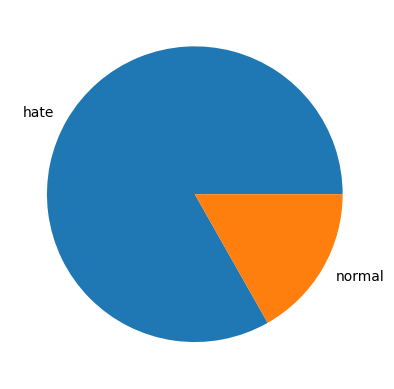

In [21]:
plt.pie(df["class"].value_counts().values, labels = le.inverse_transform(df["class"].value_counts().keys()))
plt.show()

In [22]:
hate_count, normal_count = df["class"].value_counts()

hate_class = df[df["class"] == 0]
normal_class = df[df["class"] == 1]

normal_class_upsample = normal_class.sample(hate_count, replace = True)

In [23]:
balanced_dataset = pd.concat([hate_class, normal_class_upsample])

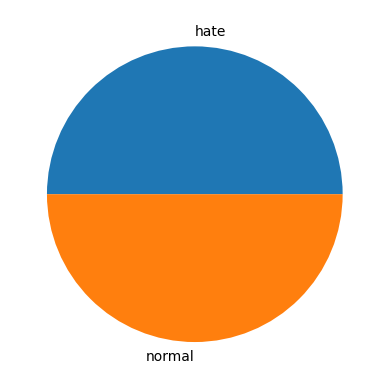

In [24]:
plt.pie(balanced_dataset["class"].value_counts().values, labels = le.inverse_transform(balanced_dataset["class"].value_counts().keys()))
plt.show()

In [25]:
balanced_dataset.shape

(41240, 2)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(balanced_dataset["tweet"], balanced_dataset["class"], test_size = 0.2, random_state = 42, stratify = balanced_dataset["class"])
X_train.shape, X_test.shape

((32992,), (8248,))

In [31]:
max_words = 100
max_len = 50

token = Tokenizer(num_words=max_words, lower=True, split=' ')

token.fit_on_texts(X_train)

Training_seq = token.texts_to_sequences(X_train)

Training_pad = pad_sequences(Training_seq,
                             maxlen=50)

Testing_seq = token.texts_to_sequences(X_test)
Testing_pad = pad_sequences(Testing_seq,
                            maxlen=50)

In [32]:
classifier_xgb= XGBClassifier()
classifier_xgb.fit(Training_pad, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

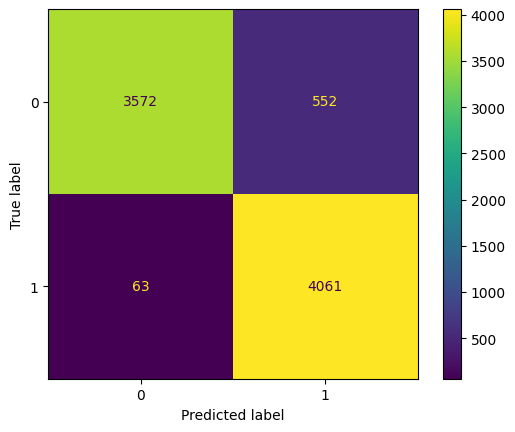

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = classifier_xgb.predict(Testing_pad)
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.show()


In [35]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9254364694471388

In [37]:
import pickle
pickle.dump(classifier_xgb, open("traditional_model.h5" ,"wb"))